## In-class activity: Linear elastic problem {#sec-fem-with-ad}


In this exercise, we solve a linear elastic problem. To this end, we define a `2D` square domain which is fixed in space (both in $x$ and $y$ directions) on the left edge. On the right edge, we apply a displacement in $x$ direction.

**Objective**:

- Define a mesh for a unit square with linear triangular elements.
- Define material property (here we use a linear elastic material with first Lame parameter $\lambda=1.0$ and shear modulus $\mu=0.5$).
- Define a function to compute the total internal energy of the system.
  - Use `Operator.grad` to compute the gradient of the displacement field for computing strain tensor.
  - Use `Operator.integrate` to integrate the strain energy density over the domain.
- Compute the internal force vector and the stiffness matrix using automatic differentiation.
  - Use `jax.jacrev` to compute the internal force vector from the total energy.
    $$ 
    \boldsymbol{f}_{\text{int}} = \frac{\partial \Psi_{\text{int}}}{\partial \boldsymbol{u}} 
    $$
  - Use `jax.jacfwd` to compute the stiffness matrix from the internal force vector.
      $$ 
      \mathbf{K} = \frac{\partial \boldsymbol{f}_{\text{int}}}{ \partial \boldsymbol{u}} 
      $$

  - Solve the system of equations to get the displacement field.
    $$
    \boldsymbol{u} = \mathbf{K}^{-1} ( \boldsymbol{f}_{\text{ext}} - \boldsymbol{f}_{\text{int}})
    $$
- Plot the von-mises stress and the displacement field.



Lets start with necessary modules and libraries we will use to solve the problem.


In [ ]:
# | code-fold: true
# | code-summary: "Code: Import essential libraries"

import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
from jax import Array
import jax.numpy as jnp


from jax_autovmap import autovmap

from tatva import Mesh, Operator, element
from tatva.plotting import (
    STYLE_PATH,
    plot_element_values,
    plot_nodal_values,
)

import matplotlib.pyplot as plt

## Creating a mesh

First, we start with creating a mesh for a unit square. To this end, we use the `Mesh.unit_square` function which creates a mesh for a unit square with a given number of elements in the $x$ and $y$ directions.


In [2]:
mesh = Mesh.unit_square(10, 10)

n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

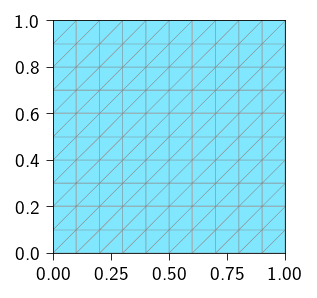

In [3]:
# | code-fold: true
# | fig-align: center
# | fig-cap: "A mesh of a unit square"
# | code-summary: "Code: Plot a mesh"
# | label: fig-mesh-square

plt.style.use(STYLE_PATH)
plt.figure(figsize=(2, 2), layout="constrained")
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    edgecolors="gray",
    lw=0.2,
    cmap="managua_r",
)
plt.gca().set_aspect("equal")
plt.gca().margins(0, 0)
plt.show()

## Computing total internal energy


In this exercise, the only physical process that contributes to the total
internal energy is the elastic deformation of the material. Therefore,

$$
\Psi_{\text{int}} = \Psi_{\text{e}} = \int_{\Omega} \psi(x) dx
$$

where $\psi(x)$ is the linear elastic energy density which is a function of the
stress and strain tensors. The linear elastic energy density can be written as,

$$
\psi(x) =  \boldsymbol{\sigma}(\boldsymbol{\varepsilon}(\boldsymbol{u})) : \boldsymbol{\varepsilon}(\boldsymbol{u})
$$

where $\boldsymbol{\sigma}$ is the stress tensor and $\boldsymbol{\varepsilon}$ is the strain tensor.

Since we assume a linear elastic material, the stress can be expressed as a
function of the strain.

$$
\boldsymbol{\sigma} = \lambda \text{tr}(\boldsymbol{\varepsilon}) \mathbf{I} + 2\mu \boldsymbol{\varepsilon}
$$
where $\lambda$ and $\mu$ are the Lamé parameters which are material properties. Assuming that the displacement field is small, the strain can be approximated as,

$$
\boldsymbol{\varepsilon} = \frac{1}{2} (\nabla \boldsymbol{u} + \nabla \boldsymbol{u}^T)
$$




To ease the handling of the material paramters and later on ease the integration of the material parameters for computing energy density, we define a class `Material` that can be used to define the material parameters.


In [4]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


mat = Material(mu=0.5, lmbda=1.0)

Now, we define three functions to compute the strain, stress, and strain energy.

In [5]:
@autovmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)


@autovmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@autovmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sig, eps)

## Computing the total internal energy

In order to compute the total internal energy, we need to perform the following operations:

- Compute the strain tensor from the displacements
- Integrate the strain energy density over the domain

In `tatva`, we define a operator class that is capable of performing various mathematical operations on the mesh. To perform these operations, the operator class requires the following information:

- The mesh (nodes and elements)
- The element type (e.g. triangle)

Below, we define such an operator that can perform the above operations over `triangular` elements.


In [6]:
tri = element.Tri3()
op = Operator(mesh, tri)

Now we can define a function that takes the nodal displacements and uses the above defined `op` to compute the gradient of the displacement field (using `op.grad`), compute the energy density based on the function `strain_energy` defined and finally integrate the energy density over the domain to get the total internal energy (using `op.integrate`). Please see the [@sec-basics] for more details on the `Operator` class.


In [7]:
@jax.jit
def total_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_grad = op.grad(u)
    energy_density = strain_energy(u_grad, mat.mu, mat.lmbda)
    return op.integrate(energy_density)

## Computing the internal force vector and the stiffness matrix

We can use the `JAX` library to compute the gradient and Hessian of the total energy (see [@sec-jax] for more details).
The gradient is the internal force vector and the Hessian is the stiffness matrix.
Therefore,

$$
\boldsymbol{f}_\text{int} = \dfrac{\partial \Psi_{\text{int}}}{ \partial \boldsymbol{u}} 
$$

and

$$ 
\mathbf{K} = \dfrac{ \partial \boldsymbol{f}_\text{int}}{ \partial\boldsymbol{u}} 
$$


In [8]:
gradient = jax.jacrev(total_energy)
hessian = jax.jacfwd(gradient)

## Applying Dirichlet boundary conditions

Now we locate the nodes that are associated with the Dirichlet boundary conditions. We will need the nodes to get the corresponding degrees of freedom. Since in this problem we prescribe the displacement on the left and right edges, we find the nodes at these two edges.


In [9]:
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)

free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)


prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.3)

## Solve system

Now we solve the problem for equilibrium condition.

$$
\boldsymbol{f}_{\text{int}}(\boldsymbol{u}) -  \boldsymbol{f}_{\text{ext}} = \boldsymbol{0}
$$

Taking initial guess for the displacement field as the prescribed values, _i.e._ $\boldsymbol{u}^{0} + d\boldsymbol{u}$, we can write the above equation as,

$$
\boldsymbol{f}_{\text{int}}(\boldsymbol{u}^{0} + \Delta\boldsymbol{u}) -  \boldsymbol{f}_{\text{ext}} = \boldsymbol{0}
$$

Using Taylor series expansion, we can write,

$$
\boldsymbol{f}_{\text{int}}(\boldsymbol{u}^{0} + \Delta\boldsymbol{u}) = \boldsymbol{f}_{\text{int}}(\boldsymbol{u}^{0}) + \frac{\partial \boldsymbol{f}_{\text{int}}}{ \partial \boldsymbol{u}}\big |_{u=u^{0}} \cdot \Delta\boldsymbol{u}
$$


This gives us 

$$
\frac{\partial \boldsymbol{f}_{\text{int}}}{ \partial \boldsymbol{u}}\big |_{u=u^{0}} \cdot \Delta\boldsymbol{u} =\underbrace{\boldsymbol{f}_{\text{ext}} - \boldsymbol{f}_{\text{int}}(\boldsymbol{u}^{0})}_{\boldsymbol{r}}
$$

where $\boldsymbol{r}$ is the residual vector, $\frac{\partial \boldsymbol{f}_{\text{int}}}{ \partial \boldsymbol{u}}\big |_{u=u^{0}}$ is the stiffness matrix ($\mathbf{K}$) evaluated at the initial guess and $\Delta\boldsymbol{u}$ is the unknown displacement vector. We need to solve the above equation such that the $\Delta\boldsymbol{u}$ at fixed degrees of freedom is zero. This is because we know the values of the displacement at the fixed degrees of freedom and that is already included in the initial guess. So, the linear system of equations is,

$$
\mathbf{K} \Delta\boldsymbol{u} = \boldsymbol{r}
$$

such that $\Delta\boldsymbol{u}|_\text{fixed\_dofs} = \boldsymbol{0}$.


### Lifting approach

::: {.callout-note}
We apply the condition $\Delta\boldsymbol{u}|_\text{fixed\_dofs} = \boldsymbol{0}$ using matrix lifting approach.
:::


We arrange the system such that the unknown vector $\Delta \boldsymbol{u}$ is flattened. Once we find the solution, we will reshape it back to the original shape.

1. create the unknown vector $\Delta \boldsymbol{u}$ with the shape of the number of nodes times the number of degrees of freedom per node
2. create the system matrix $\mathbf{K}$ and the right-hand side vector $\boldsymbol{r}$.
3. solve the system $\mathbf{K} \Delta \boldsymbol{u} = \boldsymbol{r}$ for $\Delta \boldsymbol{u}$


In the lifting approach (or partitioning approach), we separate the unknown vector $\boldsymbol{u}$ into two parts:

- $\Delta \boldsymbol{u}_f$ is the vector of unknown displacements at the free nodes
- $\Delta \boldsymbol{u}_c$ is the vector of known displacements at the constrained nodes

As a result, the system matrix $\mathbf{K}$ is partitioned into four blocks:

$$
\mathbf{K} = \begin{bmatrix}
\mathbf{K}_{ff} & \mathbf{K}_{fc} \\
\mathbf{K}_{cf} & \mathbf{K}_{cc}
\end{bmatrix}
$$

where $\mathbf{K}_{ff}$ is the stiffness matrix of the free nodes, $\mathbf{K}_{fc}$ is the
stiffness matrix of the free nodes to the constrained nodes, $\mathbf{K}_{cf}$ is the stiffness matrix of the constrained nodes to the free nodes, and $\mathbf{K}_{cc}$ is the stiffness matrix of the constrained nodes.

The system of equations is then:

$$
\mathbf{K}_{ff} \boldsymbol{u}_f + \mathbf{K}_{fc} \boldsymbol{u}_c = \boldsymbol{r}_f
$$

$$
\mathbf{K}_{cf} \boldsymbol{u}_f + \mathbf{K}_{cc} \boldsymbol{u}_c = \boldsymbol{r}_c
$$

where $\boldsymbol{r}_f$ is the residual vector of the free nodes, and $\boldsymbol{r}_c$ is the residual vector of the constrained nodes.

In order to have $\boldsymbol{u}_c$ to be equal to the prescribed values $\boldsymbol{u}^{0}$, we need to replace $\mathbf{K}_{cc}$ with $\mathbf{I}$, $\mathbf{K}_{cf}$ with $\mathbf{0}$, and $\boldsymbol{r}_c$ with the prescribed values. This gives us the following system of equations:

$$
\mathbf{K}_{ff} \Delta \boldsymbol{u}_f = \boldsymbol{r}_f
$$

$$
\mathbf{I} \Delta \boldsymbol{u}_c = \boldsymbol{0}
$$

In the lifting approach, we make all the columns and rows related to Dirichlet boundary conditions to be identity row/column. This converts the system of equations into a block diagonal system of equations.

$$
\mathbf{K}_\text{lifted} = \begin{bmatrix}
\mathbf{K}_{ff} & \mathbf{0} \\
\mathbf{0} & \mathbf{I}
\end{bmatrix} 
$$

Similarly, we also have to lift the residual vector to account for the zero displacement conditions. 

$$
\boldsymbol{r}_\text{lifted} = \begin{bmatrix}
\boldsymbol{r}_f \\
\boldsymbol{0}
\end{bmatrix}
$$

Then we can use linear solver to solve for $\Delta \boldsymbol{u}_f$ from the following system of equations:

$$
\mathbf{K}_\text{lifted} \Delta \boldsymbol{u}_f = \boldsymbol{r}_\text{lifted}
$$

Once we have $\Delta \boldsymbol{u}_f$, we can get the total displacement field as:

$$
\boldsymbol{u} = \boldsymbol{u}_0 + \Delta \boldsymbol{u}_f
$$

::: {.callout-note}
Alternatively, we could have also solved only the subproblem for the free degrees of freedom _i.e._ $\mathbf{K}_{ff} \Delta \boldsymbol{u}_f = \boldsymbol{r}_f$.
:::



In [10]:
# define the initial guess for the displacement field such that the fixed degrees of freedom are set to the prescribed values
u0 = jnp.zeros((n_dofs))
u0 = u0.at[fixed_dofs].set(prescribed_values.at[fixed_dofs].get())

# compute the hessian which is the stiffness matrix and the gradient which is the internal force vector
f_int = gradient(u0)
K = hessian(u0)
f_ext = jnp.zeros(n_dofs)

Now, we lift the stiffness matrix.


$$
\mathbf{K}_\text{lifted} = \begin{bmatrix}
\mathbf{K}_{ff} & \mathbf{0} \\
\mathbf{0} & \mathbf{I}
\end{bmatrix} 
$$

In [11]:
K_lifted = K.at[jnp.ix_(free_dofs, fixed_dofs)].set(0.0)
K_lifted = K_lifted.at[jnp.ix_(fixed_dofs, free_dofs)].set(0.0)
K_lifted = K_lifted.at[jnp.ix_(fixed_dofs, fixed_dofs)].set(jnp.eye(len(fixed_dofs)))

We can actually visualize the difference between the actual stiffness matrix and the lifted stiffness matrix.


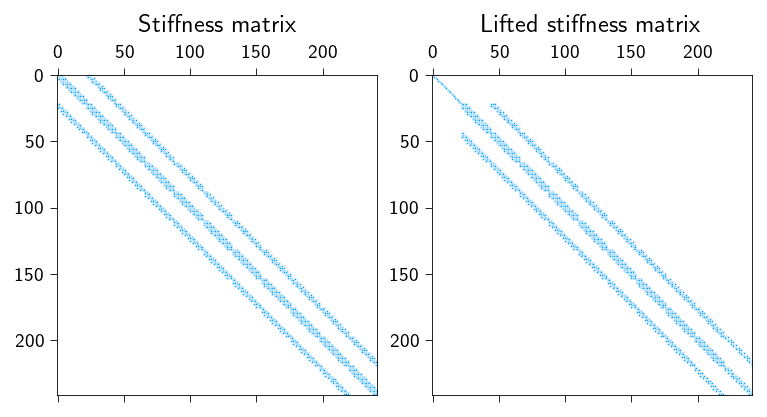

In [12]:
# | code-fold: true
# | code-summary: "Code: Plot the stiffness matrix."
# | fig-align: center
# | fig-cap: "Stiffness matrix structure for original and lifted system. Notice the absence of values at the left top corner which corresponds to the fixed degrees of freedom."
# | label: fig-stiffness-matrix

from tatva.plotting import colors

plt.style.use(STYLE_PATH)
fig, axs = plt.subplots(1, 2, figsize=(5, 3), layout="constrained")

axs[0].spy(K, color=colors.blue, markersize=1)
axs[0].set_title("Stiffness matrix")

axs[1].spy(K_lifted, color=colors.blue, markersize=1)
axs[1].set_title("Lifted stiffness matrix")

plt.show()

We also lift the residual vector to account for the zero displacement conditions  at fixed degrees of freedom.

In [13]:
r = f_ext - f_int
r_lifted = r.at[fixed_dofs].set(0.0)

Solving the problem using a direct linear solver.


In [14]:
du = jnp.linalg.solve(K_lifted, r_lifted)
u_solution = u0.at[:].add(du)
u_solution = u_solution.reshape(n_nodes, n_dofs_per_node)

## Post-processing


Now we plot the von-mises stress on the deformed mesh. The von-mises stress is computed as

$$
\sigma_{vm} = \sqrt{ \sigma_{xx}^2 + \sigma_{yy}^2 - \sigma_{xx} \sigma_{yy} + 3 \sigma_{xy}^2}
$$


In [15]:
@autovmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
stress_vm = von_mises_stress(stresses)

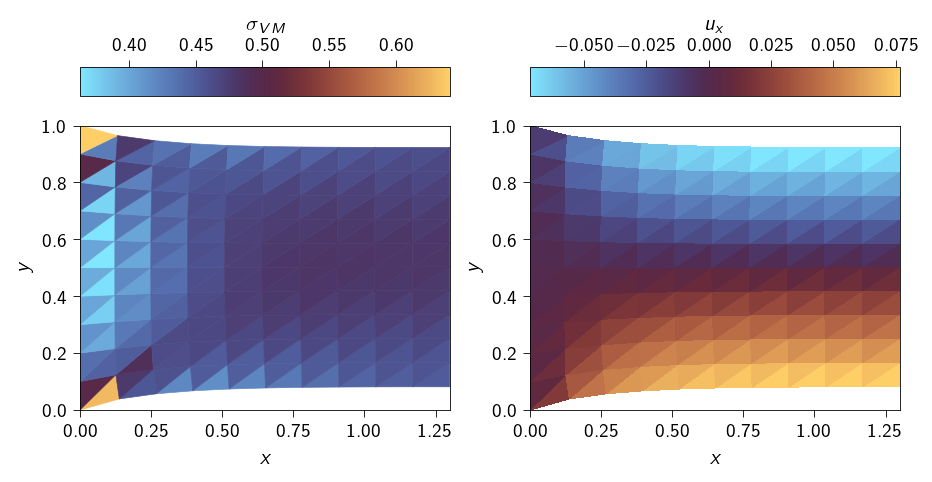

In [16]:
# | code-fold: true
# | code-summary: "Code: Plot the stress field and displacement field."
# | fig-align: center
# | fig-cap: "Stress field and displacement field on the deformed configuration."
# | label: fig-stress-field


plt.style.use(STYLE_PATH)
fig, axs = plt.subplots(1, 2, figsize=(6, 4), layout="constrained")
ax = axs[0]
plot_element_values(
    u=u_solution,
    mesh=mesh,
    values=stress_vm.flatten(),
    ax=ax,
    label=r"$\sigma_{VM}$",
)
ax.set_aspect("equal")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.margins(0.0, 0.0)


ax = axs[1]
plot_nodal_values(
    u=u_solution,
    mesh=mesh,
    nodal_values=u_solution[:, 1].flatten(),
    ax=ax,
    label=r"$u_x$",
    shading="flat",
)

ax.set_aspect("equal")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.margins(0.0, 0.0)

plt.show()